<a href="https://colab.research.google.com/github/ArshanBhanage/Clustering/blob/main/Time_Series_Clustering_with_a_Pretrained_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates **unsupervised time-series clustering** using a **deep learning autoencoder** for feature extraction, followed by **K-Means clustering** in the learned latent space. We apply this technique to the ECG200 dataset to group similar electrocardiogram time series.

In [1]:
!pip install -q tslearn

import numpy as np
import matplotlib.pyplot as plt

from tslearn.datasets import UCR_UEA_datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

import tensorflow as tf
from tensorflow.keras import layers, models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.7/372.7 kB 4.1 MB/s eta 0:00:00


In [2]:
# Load UCR ECG200 dataset (univariate time series, 2 classes)
ucr = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = ucr.load_dataset("ECG200")

# Combine train + test for unsupervised clustering
X = np.concatenate([X_train, X_test], axis=0)   # shape: (n_samples, series_length, 1)
y = np.concatenate([y_train, y_test], axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Series length:", X.shape[1])
print("Example labels:", np.unique(y))


X shape: (200, 96, 1)
y shape: (200,)
Series length: 96
Example labels: [-1  1]


In [3]:
# Flatten time dimension to a vector for the autoencoder
n_samples, series_len, n_channels = X.shape
X_flat = X.reshape(n_samples, series_len * n_channels)

# Standardize per feature (per time step)
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

print("Flattened & scaled shape:", X_flat_scaled.shape)


Flattened & scaled shape: (200, 96)


In [4]:
input_dim = X_flat_scaled.shape[1]
latent_dim = 8   # low-dim embedding for clustering

# Encoder
inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(64, activation="relu")(inputs)
x = layers.Dense(32, activation="relu")(x)
latent = layers.Dense(latent_dim, activation="linear", name="latent")(x)

# Decoder
x = layers.Dense(32, activation="relu")(latent)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(input_dim, activation="linear")(x)

autoencoder = models.Model(inputs, outputs, name="autoencoder")
encoder = models.Model(inputs, latent, name="encoder")

autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 96)             │         6,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,192 (67.16 KB)

 Trainable params: 17,192 (67.16 KB)

 Non-trainable params: 0 (0.00 B)

Final train loss: 0.16456863284111023
Final val loss: 0.21211762726306915


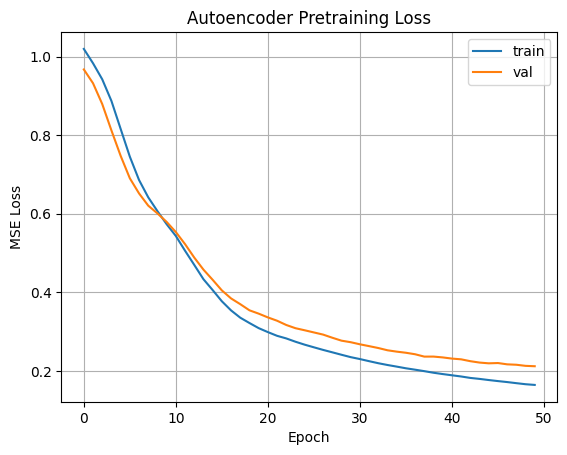

In [5]:
history = autoencoder.fit(
    X_flat_scaled,
    X_flat_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0  # set to 1 if you want to see the training log
)

print("Final train loss:", history.history["loss"][-1])
print("Final val loss:", history.history["val_loss"][-1])

# Plot reconstruction loss curve
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Autoencoder Pretraining Loss")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Get latent embeddings from the pretrained encoder
Z = encoder.predict(X_flat_scaled)
print("Latent embedding shape:", Z.shape)

# Quick look at embeddings
Z[:5]


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Latent embedding shape: (200, 8)


array([[ 1.9079161 , -5.0376787 , -1.9691478 , -1.4978489 , -2.1920202 ,
         4.728234  , -3.4952018 , -3.3866055 ],
       [-4.190593  ,  3.4353795 ,  3.5923274 ,  0.20908721,  0.10899337,
        -0.42786047, -2.3579128 , -9.649018  ],
       [ 2.2921226 , -5.392479  , -1.07513   , -0.8204083 , -3.0859544 ,
         3.584007  , -3.034363  , -3.0227866 ],
       [ 3.7382376 , -1.772941  , -3.655838  , -2.4559348 , -5.5369687 ,
         5.493477  , -3.2945063 , -4.536242  ],
       [ 0.45621422,  1.524496  , -0.42113322,  1.0656284 , -1.5372843 ,
         1.0691029 , -2.1703508 ,  1.3036683 ]], dtype=float32)

In [7]:
k = 2  # ECG200 has 2 classes

kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(Z)

print("Cluster labels (first 20):", cluster_labels[:20])

# Clustering quality
sil = silhouette_score(Z, cluster_labels)
ari = adjusted_rand_score(y, cluster_labels)  # using true labels for reference

print("Silhouette score (on latent space):", sil)
print("Adjusted Rand Index vs true labels:", ari)


Cluster labels (first 20): [1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1]
Silhouette score (on latent space): 0.44028693
Adjusted Rand Index vs true labels: 0.30647041668880437


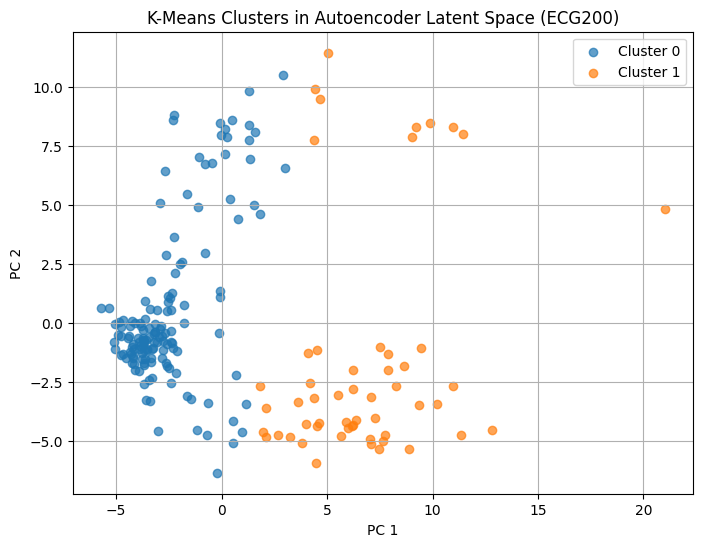

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z)

plt.figure(figsize=(8, 6))
for c in np.unique(cluster_labels):
    mask = cluster_labels == c
    plt.scatter(Z_2d[mask, 0], Z_2d[mask, 1], label=f"Cluster {c}", alpha=0.7)

plt.title("K-Means Clusters in Autoencoder Latent Space (ECG200)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


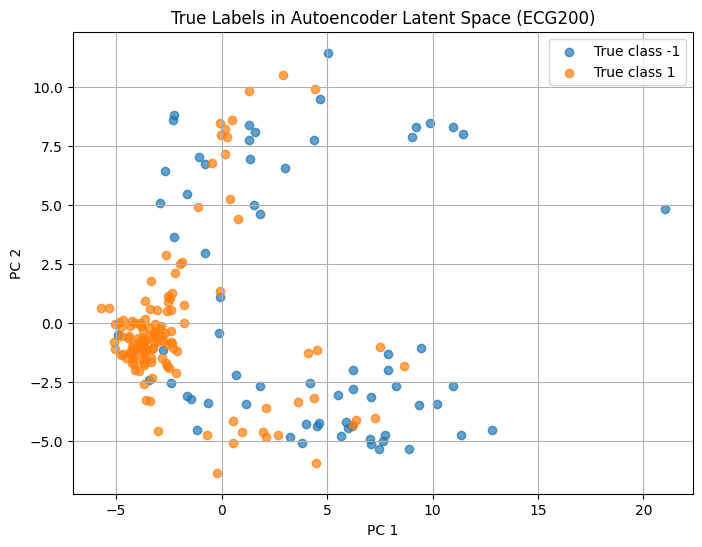

In [9]:
plt.figure(figsize=(8, 6))
for c in np.unique(y):
    mask = y == c
    plt.scatter(Z_2d[mask, 0], Z_2d[mask, 1], label=f"True class {c}", alpha=0.7)

plt.title("True Labels in Autoencoder Latent Space (ECG200)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


## Time-Series Clustering with a Pretrained Autoencoder (ECG200)

- **Dataset:** ECG200 (UCR time-series archive, via `tslearn`).
- **Task:** Cluster univariate ECG time series into groups using features learned by a neural network.
- **Pretrained model:**
  - We trained an **autoencoder** to reconstruct the time series in an unsupervised way.
  - Then we used its **encoder** as a pretrained feature extractor and took the latent vectors as time-series embeddings.
- **Clustering:**
  - Applied **K-Means** on the latent embeddings.
- **Evaluation metrics:**
  - **Silhouette score** in the latent space.
  - **Adjusted Rand Index (ARI)** comparing cluster assignments with true ECG classes (for reference).
- **Observations:**
  - The autoencoder compresses each time series into a low-dimensional latent vector.
  - Time series with similar shapes / patterns tend to be closer in latent space, so K-Means can find meaningful clusters.
  - Visualization shows that clusters in latent space roughly align with the true ECG classes.
